## Instals and Imports

In [1]:
%%capture
# !pip install torch==1.12.0 torchvision==0.13.0 torchaudio==0.12.0
# !pip install pytorch_lightning==2.1
# !pip install pandas librosa opencv-python matplotlib  #cupy-cuda110 
# !pip install -U albumentations

In [2]:
import pandas as pd
import os
import torch
from IPython.display import display, Audio
import librosa
import math
import numpy as np
import scipy
from scipy import signal as sci_signal
import cv2
import matplotlib.pyplot as plt
import gc
import sys
import numpy as np
from glob import glob
from tqdm import tqdm
import pytorch_lightning as pl
import albumentations as albu
from torchvision.models import efficientnet
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
import pandas as pd
import pandas.api.types
import sklearn.metrics
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from torch.utils.data import WeightedRandomSampler
        

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Kaggle Score 

In [3]:
class ParticipantVisibleError(Exception):
    pass


def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    '''
    Version of macro-averaged ROC-AUC score that ignores all classes that have no true positive labels.
    '''
    del solution[row_id_column_name]
    del submission[row_id_column_name]

    if not pandas.api.types.is_numeric_dtype(submission.values):
        bad_dtypes = {x: submission[x].dtype  for x in submission.columns if not pandas.api.types.is_numeric_dtype(submission[x])}
        raise ParticipantVisibleError(f'Invalid submission data types found: {bad_dtypes}')

    solution_sums = solution.sum(axis=0)
    scored_columns = list(solution_sums[solution_sums > 0].index.values)
    assert len(scored_columns) > 0

    return sklearn.metrics.roc_auc_score(solution[scored_columns].values, submission[scored_columns].values, average='macro')

## Configuration

In [61]:
class CONFIG:
    
    # == GENERAL ==
    seed = 13                             # random seed
    device = 'cuda'                         # device to be used
    mix_precision = False                   # whether to use mixed-16 precision
    
    # == DATA ==
    preprocess = True
    preprocessed_data = '../../preprocessed_data/imgs_v0/'                  # Path for processed data to be stores (Must put on .gitignore to not send to repo)
    checkpoint_dir = '../chpks/effnet_mixup_backgroundnoise'  # Checkpoints path (Must put on .gitignore to not send to repo)
    data_dir_2024 = '../../data/2024'# root folder
    sr = 32000                              # sampling rate
    n_fft = 1095                            # NFFT of Spec.
    win_len = 412                           # WIN_SIZE of Spec.
    hop_len = 100                           # overlap of Spec.
    min_freq = 100                           # min frequency
    max_freq = 16000                        # max frequency
    
    # == MODEL ==
    model = 'efficientnet_b0'               # model architecture
    
    # == DATASET ==
    batch_size = 32                         # batch size of each step
    n_workers = 4                           # number of workers
    
    # == AUG ==
    USE_HORIZFLIP = True
    USE_XYMASKING = True                    # whether use XYMasking

    # == TRAINING ==
    folds = 5                               # n fold
    epochs = 20                              # max epochs
    lr = 1e-3                               # learning rate
    weight_decay = 1e-5                     # weight decay of optimizer
    visualize = True                        # whether to visualize data and batch

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device, ', Using', torch.cuda.device_count(), 'GPU(s)')
pl.seed_everything(CONFIG.seed, workers=True)

Seed set to 13


Device: cuda:0 , Using 1 GPU(s)


13

## Preprocessing

Input: train_metadata.csv

Output: Folder com as os espectrogramas na forma de imagem.

In [6]:
df = pd.read_csv("only_pl_no_dups_5sec_leq20.csv")
df.head()

# Labels
label_list = sorted(df['label'].unique())
label_id_list = list(range(len(label_list)))
label2id = dict(zip(label_list, label_id_list))
id2label = dict(zip(label_id_list, label_list))

train_df = df[['label', 'wav_path']].copy()  # Uses only audio, label and rating.

# Create Target
train_df['target'] = train_df.label.map(label2id)

# Create Filepath
# train_df['filepath'] = CONFIG.data_dir_2024 + '/train_audio/' + train_df.filename

# Create Name
train_df['name'] = train_df.wav_path.map(lambda x: x.split('/')[0] + '-' + x.split('/')[-1].split('.')[0])

In [7]:
train_df.shape

(23176, 4)

In [8]:
train_df.head(3)

label                                           wav_path  target  \
0  asbfly  ../../preprocessed_data/5sec_wavs/asbfly_XC134...       0   
1  asbfly  ../../preprocessed_data/5sec_wavs/asbfly_XC164...       0   
2  asbfly  ../../preprocessed_data/5sec_wavs/asbfly_XC175...       0   

                 name  
0  ..-asbfly_XC134896  
1  ..-asbfly_XC164848  
2  ..-asbfly_XC175797

In [9]:
def preprocess_fn(filepath, input_audio = None):

    # LOAD .OGG
    if(input_audio is None):
        input_audio, _ = librosa.load(filepath, sr=CONFIG.sr)
    else:
        input_audio = input_audio
        
    # HANDLE NaNs
    mean_signal = np.nanmean(input_audio)
    input_audio = np.nan_to_num(input_audio, nan=mean_signal) if np.isnan(input_audio).mean() < 1 else np.zeros_like(input_audio)
    
    # SPECTROGRAM
    frequencies, times, spec_data = sci_signal.spectrogram(
        input_audio, 
        fs=CONFIG.sr, 
        nfft=CONFIG.n_fft, 
        nperseg=CONFIG.win_len, 
        noverlap=CONFIG.hop_len, 
        window='hann'
    )
    
    # FILTER LOWER AND HIGHER FREQUENCIES
    valid_freq = (frequencies >= CONFIG.min_freq) & (frequencies <= CONFIG.max_freq)
    spec_data = spec_data[valid_freq, :]
    
    # COMPUTE LOG SPEC
    spec_data = np.log10(spec_data + 1e-20)
    
    # MIN/MAX NORMALIZATION
    spec_data = spec_data - spec_data.min()
    spec_data = spec_data / spec_data.max()

    
#     print(spec_data.shape)
    # SPEC TO IMAGE
    spec_data = cv2.resize(spec_data, (256, 256), interpolation=cv2.INTER_AREA)
    
    return spec_data

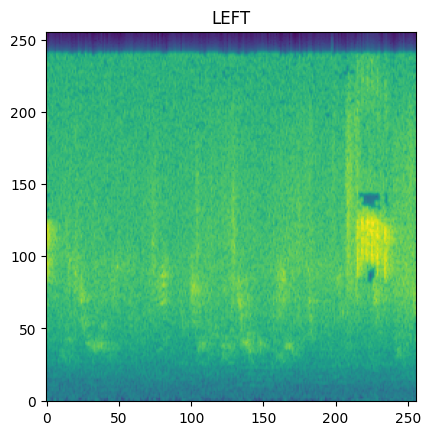

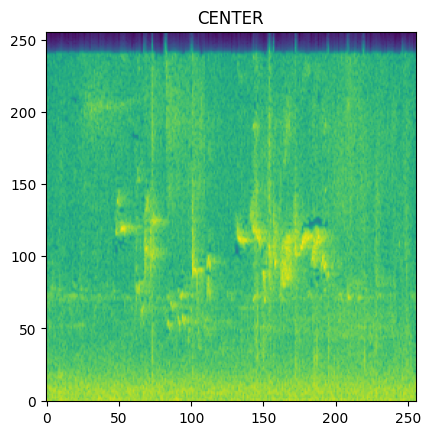

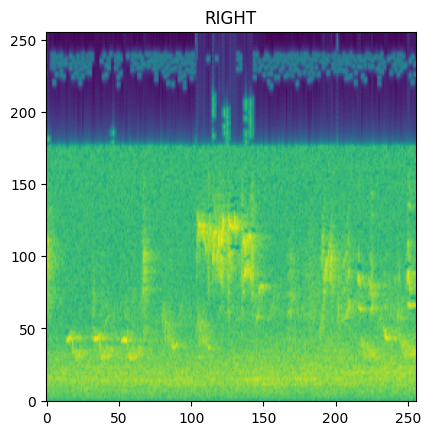

In [10]:
# Just testing

processed_spec_left = preprocess_fn(train_df['wav_path'].values[0])
processed_spec_center = preprocess_fn(train_df['wav_path'].values[1])
processed_spec_right = preprocess_fn(train_df['wav_path'].values[2])

plt.figure()
plt.title('LEFT')
plt.imshow(processed_spec_left, origin='lower')
plt.show()

plt.figure()
plt.title('CENTER')
plt.imshow(processed_spec_center, origin='lower')
plt.show()

plt.figure()
plt.title("RIGHT")
plt.imshow(processed_spec_right, origin='lower')
plt.show()

In [11]:
processed_spec_center.shape

(256, 256)

# Testing augmentations

In [12]:
ex = train_df['wav_path'].values[2]

Audio(ex)

In [13]:
speech, sr = librosa.load(ex, sr = None)
noise, sr = librosa.load('../../data/2024/unlabeled_soundscapes/2002030836.ogg', sr = None)
noise = noise[:sr*5]
# speech_power = speech.norm(p=2)
# noise_power = noise.norm(p=2)
speech_power = np.linalg.norm(speech)
noise_power = np.linalg.norm(noise)
for snr_db in [5]:
    snr = math.exp(snr_db / 10)
    scale = snr * noise_power / speech_power
    noisy_speech = (scale * speech + noise) / 2

In [14]:
scale

0.620362542512935

In [15]:
Audio(noise, rate = sr)

In [16]:
Audio(noisy_speech, rate = sr)

In [17]:
Audio(speech+noise, rate = sr)

In [18]:
import torchaudio.transforms as T
import torchaudio
import numpy

In [62]:
def play_audio(waveform, sample_rate):
    if type(waveform)!=numpy.ndarray:
        waveform = waveform.numpy()
    num_channels, num_frames = waveform.shape
    if num_channels == 1:
        display(Audio(waveform[0], rate=sample_rate))
    elif num_channels == 2:
        display(Audio((waveform[0], waveform[1]), rate=sample_rate))
    else: 
        raise ValueError("Waveform with more than 2 channels are not supported.")

In [63]:
vol=T.Vol(gain=29, gain_type='db')
waveform, sample_rate = torchaudio.load(ex)
play_audio(waveform.numpy(), sample_rate)
waveform1=vol(waveform)
play_audio(waveform1, sample_rate)
gc.collect()

Epoch 0:   0%|                                                                                  | 0/580 [11:31<?, ?it/s]


20594

In [64]:
import random
class BackgroundAugmentation(object):
    def __init__(self, min_scale, max_scale, back_df):
        self.min_scale = min_scale
        self.max_scale = max_scale
        self.backgrounds = back_df

    def __call__(self, waveform):
        numero_aleatorio = random.randint(0, len(self.backgrounds)-1)
        noise_path = self.backgrounds.wav_path.values[numero_aleatorio]
        noise, sample_rate = librosa.load(noise_path, sr = None)
        
        rand_scale = random.uniform(self.min_scale, self.max_scale)
#         print(rand_scale)
        noisy_speech = (rand_scale * waveform + noise) / 2

        return noisy_speech

In [65]:
!ls ../../preprocessed_data/5sec_unlabeleds_center/

1000170626.wav	1391330745.wav	1785138826.wav	2353770.wav    614656494.wav
1000308629.wav	1391464991.wav	1785930785.wav	235462727.wav  614798601.wav
1000389428.wav	1391863699.wav	1785997129.wav	235583699.wav  614829292.wav
1000424265.wav	1391875653.wav	1786121349.wav	235883008.wav  614921249.wav
1000450112.wav	1392469693.wav	1786216286.wav	235989232.wav  614958223.wav
1000617501.wav	1392768092.wav	178666625.wav	236516966.wav  61503073.wav
100065465.wav	1393025387.wav	1786701443.wav	236676610.wav  615363924.wav
1000771054.wav	1393083844.wav	1787199689.wav	236800088.wav  61545770.wav
1001322634.wav	1393249101.wav	1787221401.wav	236907488.wav  615676016.wav
1001358022.wav	1393303644.wav	1787576477.wav	237277741.wav  615839218.wav
100159753.wav	1393605220.wav	1787670669.wav	237361641.wav  615959305.wav
1001764212.wav	139363125.wav	1787703716.wav	237890815.wav  616589570.wav
1001973321.wav	1393754609.wav	1787710846.wav	23796497.wav   616684483.wav
100238396.wav	1393911465.wav	178778818.wav	2

131539077.wav	1703917644.wav	2094420039.wav	544919201.wav  927925839.wav
1315942641.wav	1704028424.wav	2094602620.wav	54516743.wav   928023380.wav
1315977475.wav	1704926680.wav	2094763775.wav	545477261.wav  928482533.wav
1316040993.wav	1705055056.wav	2095148666.wav	545884992.wav  928696606.wav
1316162905.wav	1705567297.wav	2095291218.wav	546141411.wav  928715591.wav
1316357016.wav	1705800290.wav	2095292892.wav	54625844.wav   928743058.wav
1316602821.wav	1706029135.wav	2095327146.wav	546580335.wav  929102331.wav
13166307.wav	1706056993.wav	2095396036.wav	546992297.wav  930555664.wav
1316756860.wav	1706192279.wav	2095682666.wav	547049096.wav  93077902.wav
1317051352.wav	1706627557.wav	209579700.wav	547570450.wav  930878413.wav
1317071054.wav	1706946627.wav	2096128452.wav	547649037.wav  930887279.wav
1317193434.wav	1707312374.wav	2096349365.wav	547751223.wav  930957949.wav
1317355680.wav	1707742727.wav	2096355021.wav	548023352.wav  931383532.wav
1317433317.wav	1708027486.wav	2096514681.wa

In [66]:
Audio('../../preprocessed_data/5sec_unlabeleds_center/783268773.wav')

In [68]:
list_augs = os.listdir('../../preprocessed_data/5sec_unlabeleds_center/')
list_augs = ['../../preprocessed_data/5sec_unlabeleds_center/' + w for w in list_augs]

ex_df = pd.DataFrame({'wav_path': list_augs})

In [69]:
ex_df.shape

(8444, 1)

In [70]:
y , sr = librosa.load(ex_df.wav_path[1], sr = None)
print(sr, y.shape)
Audio(y, rate = sr)

32000 (160000,)


In [71]:
y , sr = librosa.load(train_df.wav_path[1], sr = None)
print(sr, y.shape)
Audio(y, rate = sr)

32000 (160000,)


In [74]:
backaud = BackgroundAugmentation(0.1,2, ex_df)

In [75]:
waveform, sample_rate = librosa.load(ex, sr = None)
waveform = backaud(waveform)
Audio(waveform, rate = sample_rate)

In [76]:
waveform.shape

(160000,)

In [77]:
waveform, sample_rate = librosa.load(ex)
waveform.shape

(110250,)

In [78]:
# if not CONFIG.preprocess:
#     all_bird_data = np.load(f'{CONFIG.preprocessed_data}/spec_center_5sec_256_256.npy', allow_pickle=True).item()
# else:
#     all_bird_data = dict()
#     for i, row_metadata in tqdm(train_df.iterrows()):
        
#         # filepath to processed spec img center, left and right
#         processed_spec = preprocess_fn(row_metadata.filepath, side = 'center')
#         all_bird_data[row_metadata.name] = processed_spec.astype(np.float32)

#         processed_spec = preprocess_fn(row_metadata.filepath, side = 'left')
#         all_bird_data[row_metadata.name] = processed_spec.astype(np.float32)

#         processed_spec = preprocess_fn(row_metadata.filepath, side = 'right')
#         all_bird_data[row_metadata.name] = processed_spec.astype(np.float32)
    
#     # save to file
#     np.save(os.path.join(CONFIG.preprocessed_data, f'spec_3sides_5sec_256_256.npy'), all_bird_data)

## Dataset

In [79]:
class BirdDataset(torch.utils.data.Dataset):
    
    def __init__(
        self,
        df,
        aud_augmentation = None,
        spec_augmentation=None,
        mode='train'
    ):
        super().__init__()
        self.df = df
        self.aud_augmentation = aud_augmentation
        self.spec_augmentation = spec_augmentation
        self.mode = mode
        self.labels = np.eye(182)[self.df["target"].astype(int).values]
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        wav_path = self.df.wav_path.values[index]
        
        # load spec. data
        input_audio, sr = librosa.load(wav_path, sr = None) 
        
        # aug
        if self.aud_augmentation is not None:
#             print(input_audio.shape)
            input_audio = self.aud_augmentation(input_audio)
        
        input_spec = preprocess_fn('', input_audio = input_audio)
        
        if self.spec_augmentation is not None:
            input_spec = self.spec_augmentation(image=input_spec)['image']
        
        # target
        target = self.labels[index]
        
        
#         return torch.tensor(input_spec, dtype=torch.float32), torch.tensor(target, dtype=torch.long)
        return torch.tensor(input_spec, dtype=torch.float32) ,torch.tensor(target.astype(np.float32))

In [105]:
def get_transforms(_type):
    
    if _type == 'train':
        return albu.Compose([
            albu.GaussNoise(var_limit=(0.001, 0.01), mean=0),
            albu.HorizontalFlip(0.5) if CONFIG.USE_XYMASKING else albu.NoOp(),
            albu.XYMasking(
                p=0.3,
                num_masks_x=(1, 5),
                num_masks_y=(1, 3),
                mask_x_length=(1, 20),
                mask_y_length=(1, 15),
            ) if CONFIG.USE_XYMASKING else albu.NoOp()
        ])
    elif _type == 'valid':
        return albu.Compose([])

In [106]:
def show_batch(ds, row=3, col=3):
    fig = plt.figure(figsize=(10, 10))
    img_index = np.random.randint(0, len(ds)-1, row*col)
    
    for i in range(len(img_index)):
        img, label = dummy_dataset[img_index[i]]
        
        if isinstance(img, torch.Tensor):
            img = img.detach().numpy()
        
        ax = fig.add_subplot(row, col, i + 1, xticks=[], yticks=[])
        ax.imshow(img, cmap='jet')
        ax.set_title(f'ID: {img_index[i]}; Target: {label.argmax()}')
    
    plt.tight_layout()
    plt.show()

In [107]:
train_df

label                                           wav_path  target  \
0       asbfly  ../../preprocessed_data/5sec_wavs/asbfly_XC134...       0   
1       asbfly  ../../preprocessed_data/5sec_wavs/asbfly_XC164...       0   
2       asbfly  ../../preprocessed_data/5sec_wavs/asbfly_XC175...       0   
3       asbfly  ../../preprocessed_data/5sec_wavs/asbfly_XC207...       0   
4       asbfly  ../../preprocessed_data/5sec_wavs/asbfly_XC209...       0   
...        ...                                                ...     ...   
23171  zitcis1  ../../preprocessed_data/5sec_wavs/zitcis1_XC84...     181   
23172  zitcis1  ../../preprocessed_data/5sec_wavs/zitcis1_XC84...     181   
23173  zitcis1  ../../preprocessed_data/5sec_wavs/zitcis1_XC85...     181   
23174  zitcis1  ../../preprocessed_data/5sec_wavs/zitcis1_XC85...     181   
23175  zitcis1  ../../preprocessed_data/5sec_wavs/zitcis1_XC85...     181   

                      name  fold  
0       ..-asbfly_XC134896     1  
1       ..-asbfly_XC164848     1  
2       ..-asbfly_XC175797     2  
3       ..-asbfly_XC207738     4  
4       ..-asbfly_XC209218     0  
...                    ...   ...  
23171  ..-zitcis1_XC845747     4  
23172  ..-zitcis1_XC845817     4  
23173  ..-zitcis1_XC856176     2  
23174  ..-zitcis1_XC856723     4  
23175  ..-zitcis1_XC858550     4  

[23176 rows x 5 columns]

(256, 256)


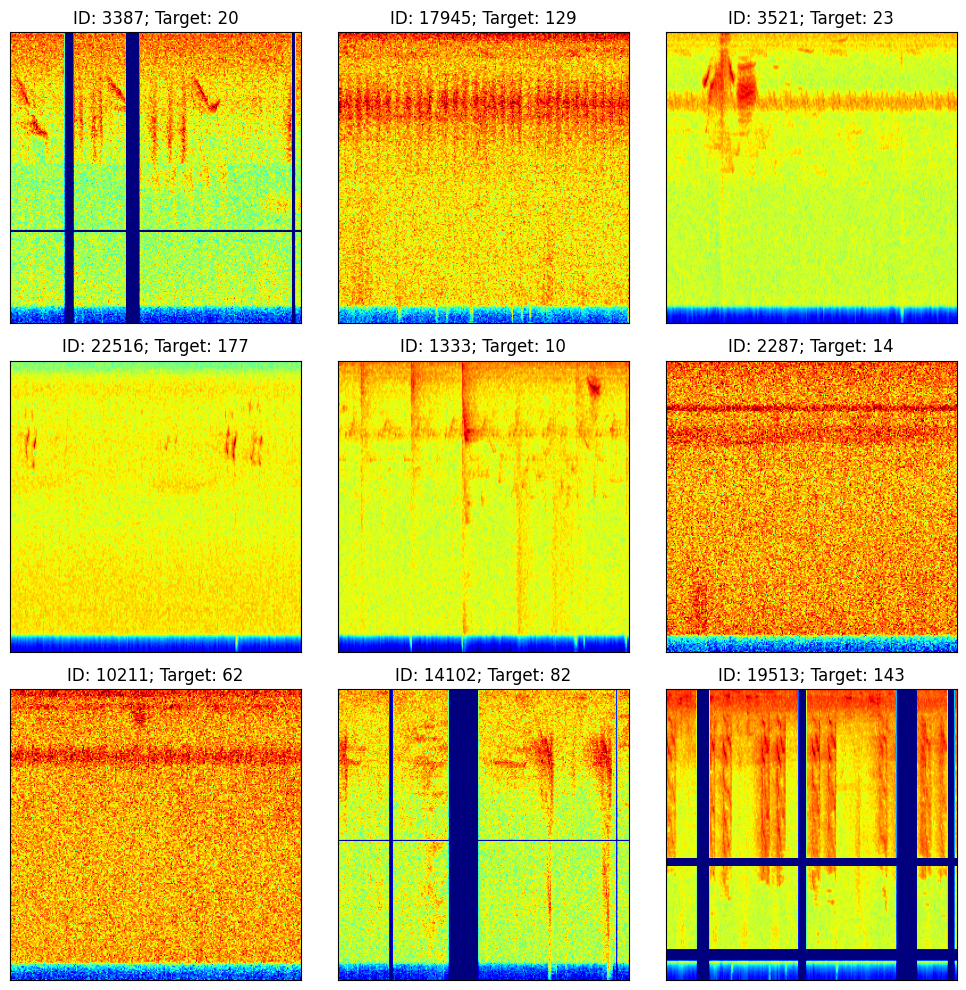

17952

In [108]:
dummy_dataset = BirdDataset(train_df, backaud , get_transforms('train'))

test_input, test_target = dummy_dataset[0]
print(test_input.detach().numpy().shape)

show_batch(dummy_dataset)

del dummy_dataset
gc.collect()


## Cross-Validation

In [109]:
kf = StratifiedKFold(n_splits=CONFIG.folds, shuffle=True, random_state=CONFIG.seed)
train_df['fold'] = 0
for fold, (train_idx, val_idx) in enumerate(kf.split(train_df, y=train_df['target'])):
    for idx in val_idx:
        train_df.iloc[idx, train_df.columns.get_loc('fold') ] = fold

In [110]:
train_df.fold.value_counts()

0    4636
1    4635
2    4635
4    4635
3    4635
Name: fold, dtype: int64

## Model

In [111]:
class EffNet(nn.Module):
    
    def __init__(self, model_type, n_classes, pretrained=True):
        super().__init__()
        
        if model_type == 'efficientnet_b0':
            if pretrained: weights = efficientnet.EfficientNet_B0_Weights.DEFAULT
            else: weights = None
            self.base_model = efficientnet.efficientnet_b0(weights=weights)
        elif model_type == 'efficientnet_b1':
            if pretrained: weights = efficientnet.EfficientNet_B1_Weights.DEFAULT
            else: weights = None
            self.base_model = efficientnet.efficientnet_b1(weights=weights)
        elif model_type == 'efficientnet_b2':
            if pretrained: weights = efficientnet.EfficientNet_B2_Weights.DEFAULT
            else: weights = None
            self.base_model = efficientnet.efficientnet_b2(weights=weights)
        elif model_type == 'efficientnet_b3':
            if pretrained: weights = efficientnet.EfficientNet_B3_Weights.DEFAULT
            else: weights = None
            self.base_model = efficientnet.efficientnet_b3(weights=weights)
        else:
            raise ValueError('model type not supported')
        
        self.base_model.classifier[1] = nn.Linear(self.base_model.classifier[1].in_features, n_classes, dtype=torch.float32)
    
    def forward(self, x):
        x = x.unsqueeze(1)
#         x = torch.cat([x, x, x], dim=3).permute(0, 3, 1, 2)
        x = x.expand(-1, 3, -1, -1)
        return self.base_model(x)
    
class EffNet_onnx(nn.Module):
    
    def __init__(self, model_type, n_classes, pretrained=True):
        super().__init__()
        
        if model_type == 'efficientnet_b0':
            if pretrained: weights = efficientnet.EfficientNet_B0_Weights.DEFAULT
            else: weights = None
            self.base_model = efficientnet.efficientnet_b0(weights=weights)
        elif model_type == 'efficientnet_b1':
            if pretrained: weights = efficientnet.EfficientNet_B1_Weights.DEFAULT
            else: weights = None
            self.base_model = efficientnet.efficientnet_b1(weights=weights)
        elif model_type == 'efficientnet_b2':
            if pretrained: weights = efficientnet.EfficientNet_B2_Weights.DEFAULT
            else: weights = None
            self.base_model = efficientnet.efficientnet_b2(weights=weights)
        elif model_type == 'efficientnet_b3':
            if pretrained: weights = efficientnet.EfficientNet_B3_Weights.DEFAULT
            else: weights = None
            self.base_model = efficientnet.efficientnet_b3(weights=weights)
        else:
            raise ValueError('model type not supported')
        
        self.base_model.classifier[1] = nn.Linear(self.base_model.classifier[1].in_features, n_classes, dtype=torch.float32)
    
    def forward(self, x):
        x = x.unsqueeze(-1)
        x = torch.cat([x, x, x], dim=3).permute(0, 3, 1, 2) #Dont know why with expand, onnx took so much time to infer
#         x = x.expand(-1, 3, -1, -1)
        return self.base_model(x)

In [112]:
%%time
dummy_model = EffNet(CONFIG.model, n_classes=len(label_list))

dummy_input = torch.randn(64, 256, 256)
print(dummy_model(dummy_input).shape)


torch.Size([64, 182])
CPU times: user 24.6 s, sys: 19.1 s, total: 43.7 s
Wall time: 1.95 s


In [113]:
from torch.distributions import Beta
class Mixup(nn.Module):
    def __init__(self, mix_beta):

        super(Mixup, self).__init__()
        self.beta_distribution = Beta(mix_beta, mix_beta)

    def forward(self, X, Y, weight=None):

        bs = X.shape[0]
        n_dims = len(X.shape)
        perm = torch.randperm(bs)
        coeffs = self.beta_distribution.rsample(torch.Size((bs,))).to(X.device)

        if n_dims == 2:
            X = coeffs.view(-1, 1) * X + (1 - coeffs.view(-1, 1)) * X[perm]
        elif n_dims == 3:
            X = coeffs.view(-1, 1, 1) * X + (1 - coeffs.view(-1, 1, 1)) * X[perm]
        else:
            X = coeffs.view(-1, 1, 1, 1) * X + (1 - coeffs.view(-1, 1, 1, 1)) * X[perm]

        Y = coeffs.view(-1, 1) * Y + (1 - coeffs.view(-1, 1)) * Y[perm]

        if weight is None:
            return X, Y
        else:
            weight = coeffs.view(-1) * weight + (1 - coeffs.view(-1)) * weight[perm]
            return X, Y, weight

In [115]:
mixup = Mixup(1)

In [116]:
a, b = mixup(test_input.unsqueeze(0), test_target.unsqueeze(0))

In [117]:
a.shape, b.shape

(torch.Size([1, 256, 256]), torch.Size([1, 182]))

In [118]:
b

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])

## Lightning Module

In [119]:
class BirdModel(pl.LightningModule):
    
    def __init__(self):
        super().__init__()
        
        # == backbone ==
        self.backbone = EffNet(CONFIG.model, n_classes=len(label_list))
        
        # == loss function ==
        self.loss_fn = nn.CrossEntropyLoss()
#         self.loss_fn = nn.BCEWithLogitsLoss(reduction="none")
    
        self.mixup = Mixup(mix_beta=1)
        
        # == record ==
        self.validation_step_outputs = []
        
    def forward(self, images):
        return self.backbone(images)
    
    def configure_optimizers(self):
        
        # == define optimizer ==
        model_optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, self.parameters()),
            lr=CONFIG.lr,
            weight_decay=CONFIG.weight_decay
        )
        
        # == define learning rate scheduler ==
        lr_scheduler = CosineAnnealingWarmRestarts(
            model_optimizer,
            T_0=CONFIG.epochs,
            T_mult=1,
            eta_min=1e-6,
            last_epoch=-1
        )
        
        return {
            'optimizer': model_optimizer,
            'lr_scheduler': {
                'scheduler': lr_scheduler,
                'interval': 'epoch',
                'monitor': 'val_loss',
                'frequency': 1
            }
        }
    
    def training_step(self, batch, batch_idx):
        
        # == obtain input and target ==
        image, target = batch
        image = image.to(self.device)
        target = target.to(self.device)
        
#         num_classes = 182

        
        image, target = self.mixup(image, target)
        
        # == pred ==
        y_pred = self(image)
        
        # == compute loss ==
        train_loss = self.loss_fn(y_pred, target)
        
        # == record ==
        self.log('train_loss', train_loss, True)
        
        return train_loss
    
    def validation_step(self, batch, batch_idx):
        
        # == obtain input and target ==
        image, target = batch
        image = image.to(self.device)
        target = target.to(self.device)
        
        # == pred ==
        with torch.no_grad():
            y_pred = self(image)
            
        self.validation_step_outputs.append({"logits": y_pred, "targets": target})
        
    def train_dataloader(self):
        return self._train_dataloader

    def validation_dataloader(self):
        return self._validation_dataloader
    
    def on_validation_epoch_end(self):
        
        # = merge batch data =
        outputs = self.validation_step_outputs
        
        output_val = nn.Softmax(dim=1)(torch.cat([x['logits'] for x in outputs], dim=0)).cpu().detach()
        target_val = torch.cat([x['targets'] for x in outputs], dim=0).cpu().detach()
        
        # target to one-hot
#         target_val = torch.nn.functional.one_hot(target_val, len(label_list)).float()
        
        # = compute validation loss =
        val_loss = self.loss_fn(output_val, target_val)
        
        
        
        # = val with ROC AUC =
        gt_df = pd.DataFrame(target_val.numpy().astype(np.float32), columns=label_list)
        pred_df = pd.DataFrame(output_val.numpy().astype(np.float32), columns=label_list)
        
        gt_df['id'] = [f'id_{i}' for i in range(len(gt_df))]
        pred_df['id'] = [f'id_{i}' for i in range(len(pred_df))]
        
        val_score = score(gt_df, pred_df, row_id_column_name='id')
        
        self.log("val_score", val_score, True)
        
        # clear validation outputs
        self.validation_step_outputs = list()
        
        return {'val_loss': val_loss, 'val_score': val_score}

## Training Loop

In [120]:
def predict(data_loader, model):
    model.to(CONFIG.device)
    model.eval()
    predictions = []
    gts = []
    for batch in tqdm(data_loader):
        with torch.no_grad():
            x, y = batch
            x = x.cuda()
            outputs = model(x)
            outputs = nn.Softmax(dim=1)(outputs)
        predictions.append(outputs.detach().cpu())
        gts.append(y.detach().cpu())
    
    predictions = torch.cat(predictions, dim=0).cpu().detach()
    gts = torch.cat(gts, dim=0).cpu().detach()
#     gts = torch.nn.functional.one_hot(gts, len(label_list))
    return predictions.numpy().astype(np.float32), gts.numpy().astype(np.float32)

In [121]:
def run_training(fold_id, total_df):
    print('================================================================')
    print(f"==== Running training for fold {fold_id} ====")
    
    # == create dataset and dataloader ==
    train_df = total_df[total_df[f'fold'] != fold_id].copy()
    valid_df = total_df[total_df[f'fold'] == fold_id].copy()
    
    print(f'Train Samples: {len(train_df)}')
    print(f'Valid Samples: {len(valid_df)}')

    # == create a sampler that samples inversely of its counts ==
    y_train = train_df['target']
    class_sample_count = np.array([len(np.where(y_train == t)[0]) for t in np.unique(y_train)])
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in y_train])
    samples_weight = torch.from_numpy(samples_weight)
    
    sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))
    
    
    train_ds = BirdDataset(train_df, backaud, get_transforms('train'), 'train')
    val_ds = BirdDataset(valid_df, backaud, get_transforms('valid'), 'valid')
    
    train_dl = torch.utils.data.DataLoader(
        train_ds,
        batch_size=CONFIG.batch_size,
        shuffle=False, # If using sampler must be False
        num_workers=CONFIG.n_workers,
        pin_memory=True,
        persistent_workers=True,
        sampler = sampler
    )
    
    val_dl = torch.utils.data.DataLoader(
        val_ds,
        batch_size=CONFIG.batch_size * 2,
        shuffle=False,
        num_workers=CONFIG.n_workers,
        pin_memory=True,
        persistent_workers=True
    )
    
    # == init model ==
    bird_model = BirdModel()
    
    # == init callback ==
    checkpoint_callback = ModelCheckpoint(monitor='val_score',
                                          dirpath=CONFIG.checkpoint_dir,
                                          save_top_k=1,
                                          save_last=False,
                                          save_weights_only=True,
                                          filename=f"fold_{fold_id}",
                                          mode='max')
    callbacks_to_use = [checkpoint_callback, TQDMProgressBar(refresh_rate=1)]
    
    # == init trainer ==
    trainer = pl.Trainer(
        max_epochs=CONFIG.epochs,
        val_check_interval=0.5,
        callbacks=callbacks_to_use,
        enable_model_summary=False,
        accelerator="gpu",
        deterministic=True,
        precision='16-mixed' if CONFIG.mix_precision else 32,
    )
    
    # == Training ==
    trainer.fit(bird_model, train_dataloaders=train_dl, val_dataloaders=val_dl)
    
    # == Prediction ==
    best_model_path = checkpoint_callback.best_model_path
    weights = torch.load(best_model_path)['state_dict']
    bird_model.load_state_dict(weights)
    
    preds, gts = predict(val_dl, bird_model)
    
    # = create dataframe =
    pred_df = pd.DataFrame(preds, columns=label_list)
    pred_df['id'] = np.arange(len(pred_df))
    gt_df = pd.DataFrame(gts, columns=label_list)
    gt_df['id'] = np.arange(len(gt_df))
    
    # = compute score =
    val_score = score(gt_df, pred_df, row_id_column_name='id')
    
    # == save to file ==
    pred_cols = [f'pred_{t}' for t in label_list]
    valid_df = pd.concat([valid_df.reset_index(), pd.DataFrame(np.zeros((len(valid_df), len(label_list)*2)).astype(np.float32), columns=label_list+pred_cols)], axis=1)
    valid_df[label_list] = gts
    valid_df[pred_cols] = preds
    valid_df.to_csv(f"{CONFIG.checkpoint_dir}/pred_df_f{fold_id}.csv", index=False)
    
    return preds, gts, val_score

## RUN

In [122]:
train_df.head(), train_df.target.nunique()

(    label                                           wav_path  target  \
 0  asbfly  ../../preprocessed_data/5sec_wavs/asbfly_XC134...       0   
 1  asbfly  ../../preprocessed_data/5sec_wavs/asbfly_XC164...       0   
 2  asbfly  ../../preprocessed_data/5sec_wavs/asbfly_XC175...       0   
 3  asbfly  ../../preprocessed_data/5sec_wavs/asbfly_XC207...       0   
 4  asbfly  ../../preprocessed_data/5sec_wavs/asbfly_XC209...       0   
 
                  name  fold  
 0  ..-asbfly_XC134896     1  
 1  ..-asbfly_XC164848     1  
 2  ..-asbfly_XC175797     2  
 3  ..-asbfly_XC207738     4  
 4  ..-asbfly_XC209218     0  ,
 182)

In [ ]:
# training
torch.set_float32_matmul_precision('high')

seed = CONFIG.seed
random.seed(seed)
torch.manual_seed(seed)

# record
fold_val_score_list = list()
oof_df = train_df.copy()
pred_cols = [f'pred_{t}' for t in label_list]
oof_df = pd.concat([oof_df, pd.DataFrame(np.zeros((len(oof_df), len(pred_cols)*2)).astype(np.float32), columns=label_list+pred_cols)], axis=1)

for f in range(CONFIG.folds):
    
    # get validation index
    val_idx = list(train_df[train_df[f'fold'] == f].index)
    
    # main loop of f-fold
    val_preds, val_gts, val_score = run_training(f, train_df)
    
    # record
    oof_df.loc[val_idx, label_list] = val_gts
    oof_df.loc[val_idx, pred_cols] = val_preds
    fold_val_score_list.append(val_score)


for idx, val_score in enumerate(fold_val_score_list):
    print(f'Fold {idx} Val Score: {val_score:.5f}')

# oof_gt_df = oof_df[['samplename'] + label_list].copy()
# oof_pred_df = oof_df[['samplename'] + pred_cols].copy()
# oof_pred_df.columns = ['samplename'] + label_list
# oof_score = score(oof_gt_df, oof_pred_df, 'samplename')
# print(f'OOF Score: {oof_score:.5f}')

oof_df.to_csv(f"{CONFIG.checkpoint_dir}/oof_pred.csv", index=False)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


==== Running training for fold 0 ====
Train Samples: 18540
Valid Samples: 4636


/usr/local/lib/python3.8/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:630: Checkpoint directory ../chpks/effnet_mixup_backgroundnoise exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 0:  50%|█████████████████████▌                     | 290/580 [01:07<01:07,  4.30it/s, v_num=132, train_loss=4.950]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  85%|█████████████████████████████████████████████████▎        | 62/73 [00:15<00:02,  4.07it/s]


Epoch 0: 100%|██████████████████████████| 580/580 [02:30<00:00,  3.86it/s, v_num=132, train_loss=5.110, val_score=0.765]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  70%|████████████████████████████████████████▌                 | 51/73 [00:12<00:05,  4.20it/s]


Epoch 1:  50%|█████████████             | 290/580 [01:03<01:03,  4.57it/s, v_num=132, train_loss=4.570, val_score=0.848]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  55%|███████████████████████████████▊                          | 40/73 [00:09<00:07,  4.41it/s]


Epoch 1: 100%|██████████████████████████| 580/580 [02:24<00:00,  4.01it/s, v_num=132, train_loss=4.030, val_score=0.883]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  40%|███████████████████████                                   | 29/73 [00:07<00:10,  4.13it/s]


Epoch 2:  50%|█████████████             | 290/580 [01:03<01:03,  4.58it/s, v_num=132, train_loss=3.440, val_score=0.890]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  25%|██████████████▎                                           | 18/73 [00:04<00:12,  4.44it/s]


Epoch 2: 100%|██████████████████████████| 580/580 [02:25<00:00,  3.99it/s, v_num=132, train_loss=4.360, val_score=0.900]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  10%|█████▋                                                     | 7/73 [00:01<00:10,  6.54it/s]


Validation DataLoader 0: 100%|██████████████████████████████████████████████████████████| 73/73 [00:17<00:00,  4.18it/s]


Epoch 3:  50%|█████████████             | 290/580 [01:02<01:02,  4.61it/s, v_num=132, train_loss=4.070, val_score=0.903]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  85%|█████████████████████████████████████████████████▎        | 62/73 [00:15<00:02,  4.10it/s]


Epoch 3: 100%|██████████████████████████| 580/580 [02:24<00:00,  4.03it/s, v_num=132, train_loss=3.060, val_score=0.913]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  70%|████████████████████████████████████████▌                 | 51/73 [00:12<00:05,  4.17it/s]


Epoch 4:  50%|█████████████             | 290/580 [01:02<01:02,  4.62it/s, v_num=132, train_loss=3.950, val_score=0.924]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  55%|███████████████████████████████▊                          | 40/73 [00:09<00:07,  4.36it/s]


Epoch 4: 100%|██████████████████████████| 580/580 [02:23<00:00,  4.03it/s, v_num=132, train_loss=3.450, val_score=0.926]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  40%|███████████████████████                                   | 29/73 [00:07<00:10,  4.11it/s]


Epoch 5:  50%|█████████████             | 290/580 [01:02<01:02,  4.62it/s, v_num=132, train_loss=3.910, val_score=0.927]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  25%|██████████████▎                                           | 18/73 [00:04<00:12,  4.45it/s]


Epoch 5: 100%|██████████████████████████| 580/580 [02:23<00:00,  4.03it/s, v_num=132, train_loss=3.690, val_score=0.931]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  10%|█████▋                                                     | 7/73 [00:01<00:09,  6.70it/s]


Validation DataLoader 0: 100%|██████████████████████████████████████████████████████████| 73/73 [00:17<00:00,  4.19it/s]


Epoch 6:  50%|█████████████             | 290/580 [01:02<01:02,  4.62it/s, v_num=132, train_loss=3.850, val_score=0.933]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  85%|█████████████████████████████████████████████████▎        | 62/73 [00:15<00:02,  4.06it/s]


Epoch 6: 100%|██████████████████████████| 580/580 [02:24<00:00,  4.01it/s, v_num=132, train_loss=3.920, val_score=0.937]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  70%|████████████████████████████████████████▌                 | 51/73 [00:12<00:05,  4.17it/s]


Epoch 7:  50%|█████████████             | 290/580 [01:02<01:02,  4.63it/s, v_num=132, train_loss=3.200, val_score=0.940]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  55%|███████████████████████████████▊                          | 40/73 [00:09<00:07,  4.32it/s]


Epoch 7: 100%|██████████████████████████| 580/580 [02:23<00:00,  4.03it/s, v_num=132, train_loss=3.910, val_score=0.942]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  40%|███████████████████████                                   | 29/73 [00:07<00:10,  4.07it/s]


Epoch 8:  50%|█████████████             | 290/580 [01:02<01:02,  4.62it/s, v_num=132, train_loss=3.020, val_score=0.939]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  25%|██████████████▎                                           | 18/73 [00:04<00:12,  4.44it/s]


Epoch 8: 100%|██████████████████████████| 580/580 [02:23<00:00,  4.04it/s, v_num=132, train_loss=2.540, val_score=0.940]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  10%|█████▋                                                     | 7/73 [00:01<00:09,  6.64it/s]


Validation DataLoader 0: 100%|██████████████████████████████████████████████████████████| 73/73 [00:17<00:00,  4.21it/s]


Epoch 9:  50%|█████████████             | 290/580 [01:02<01:02,  4.63it/s, v_num=132, train_loss=2.830, val_score=0.939]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  85%|█████████████████████████████████████████████████▎        | 62/73 [00:15<00:02,  4.12it/s]


Epoch 9: 100%|██████████████████████████| 580/580 [02:23<00:00,  4.04it/s, v_num=132, train_loss=3.130, val_score=0.943]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  70%|████████████████████████████████████████▌                 | 51/73 [00:12<00:05,  4.18it/s]


Epoch 10:  50%|████████████▌            | 290/580 [01:02<01:02,  4.63it/s, v_num=132, train_loss=3.060, val_score=0.946]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  55%|███████████████████████████████▊                          | 40/73 [00:09<00:07,  4.41it/s]


Epoch 10: 100%|█████████████████████████| 580/580 [02:23<00:00,  4.04it/s, v_num=132, train_loss=2.390, val_score=0.946]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  40%|███████████████████████                                   | 29/73 [00:07<00:10,  4.12it/s]


Epoch 11:  50%|████████████▌            | 290/580 [01:02<01:02,  4.63it/s, v_num=132, train_loss=2.990, val_score=0.946]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  25%|██████████████▎                                           | 18/73 [00:04<00:12,  4.39it/s]


Epoch 11: 100%|█████████████████████████| 580/580 [02:24<00:00,  4.02it/s, v_num=132, train_loss=3.390, val_score=0.949]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  10%|█████▋                                                     | 7/73 [00:01<00:09,  6.60it/s]


Validation DataLoader 0: 100%|██████████████████████████████████████████████████████████| 73/73 [00:17<00:00,  4.16it/s]


Epoch 12:  50%|████████████▌            | 290/580 [01:03<01:03,  4.54it/s, v_num=132, train_loss=2.370, val_score=0.950]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  85%|█████████████████████████████████████████████████▎        | 62/73 [00:15<00:02,  3.98it/s]


Epoch 12: 100%|█████████████████████████| 580/580 [02:26<00:00,  3.97it/s, v_num=132, train_loss=2.830, val_score=0.946]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  70%|████████████████████████████████████████▌                 | 51/73 [00:12<00:05,  4.24it/s]


Epoch 13:  50%|████████████▌            | 290/580 [01:03<01:03,  4.58it/s, v_num=132, train_loss=2.580, val_score=0.949]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  55%|███████████████████████████████▊                          | 40/73 [00:09<00:07,  4.37it/s]


Epoch 13: 100%|█████████████████████████| 580/580 [02:24<00:00,  4.01it/s, v_num=132, train_loss=2.330, val_score=0.953]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  40%|███████████████████████                                   | 29/73 [00:07<00:10,  4.04it/s]


Epoch 14:  50%|████████████▌            | 290/580 [01:02<01:02,  4.62it/s, v_num=132, train_loss=3.230, val_score=0.951]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  25%|██████████████▎                                           | 18/73 [00:04<00:12,  4.40it/s]


Epoch 14: 100%|█████████████████████████| 580/580 [02:23<00:00,  4.03it/s, v_num=132, train_loss=2.610, val_score=0.952]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  10%|█████▋                                                     | 7/73 [00:01<00:09,  6.76it/s]


Validation DataLoader 0: 100%|██████████████████████████████████████████████████████████| 73/73 [00:17<00:00,  4.18it/s]


Epoch 15:  50%|████████████▌            | 290/580 [01:02<01:02,  4.65it/s, v_num=132, train_loss=3.540, val_score=0.952]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  85%|█████████████████████████████████████████████████▎        | 62/73 [00:15<00:02,  4.10it/s]


Epoch 15: 100%|█████████████████████████| 580/580 [02:22<00:00,  4.06it/s, v_num=132, train_loss=4.190, val_score=0.953]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  70%|████████████████████████████████████████▌                 | 51/73 [00:12<00:05,  4.19it/s]


Epoch 16:  50%|████████████▌            | 290/580 [01:02<01:02,  4.67it/s, v_num=132, train_loss=2.700, val_score=0.952]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  55%|███████████████████████████████▊                          | 40/73 [00:09<00:07,  4.36it/s]


Epoch 16: 100%|█████████████████████████| 580/580 [02:22<00:00,  4.07it/s, v_num=132, train_loss=2.840, val_score=0.955]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  40%|███████████████████████                                   | 29/73 [00:07<00:10,  4.11it/s]


Epoch 17:  50%|████████████▌            | 290/580 [01:02<01:02,  4.67it/s, v_num=132, train_loss=2.730, val_score=0.954]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  25%|██████████████▎                                           | 18/73 [00:04<00:12,  4.43it/s]


Epoch 17: 100%|█████████████████████████| 580/580 [02:23<00:00,  4.05it/s, v_num=132, train_loss=2.240, val_score=0.954]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  10%|█████▋                                                     | 7/73 [00:01<00:10,  6.44it/s]


Validation DataLoader 0: 100%|██████████████████████████████████████████████████████████| 73/73 [00:17<00:00,  4.18it/s]


Epoch 18:  50%|████████████▌            | 290/580 [01:02<01:02,  4.62it/s, v_num=132, train_loss=2.440, val_score=0.957]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  85%|█████████████████████████████████████████████████▎        | 62/73 [00:15<00:02,  4.09it/s]


Epoch 18: 100%|█████████████████████████| 580/580 [02:23<00:00,  4.03it/s, v_num=132, train_loss=2.990, val_score=0.956]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  70%|████████████████████████████████████████▌                 | 51/73 [00:12<00:05,  4.12it/s]


Epoch 19:  50%|████████████▌            | 290/580 [01:02<01:02,  4.62it/s, v_num=132, train_loss=2.950, val_score=0.956]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  55%|███████████████████████████████▊                          | 40/73 [00:09<00:07,  4.37it/s]


Epoch 19: 100%|█████████████████████████| 580/580 [02:23<00:00,  4.03it/s, v_num=132, train_loss=3.900, val_score=0.957]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  40%|███████████████████████                                   | 29/73 [00:07<00:10,  4.13it/s]


Epoch 19: 100%|█████████████████████████| 580/580 [02:42<00:00,  3.56it/s, v_num=132, train_loss=3.900, val_score=0.958]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|█████████████████████████| 580/580 [02:42<00:00,  3.56it/s, v_num=132, train_loss=3.900, val_score=0.958]



100%|███████████████████████████████████████████████████████████████████████████████████| 73/73 [00:18<00:00,  3.86it/s]


==== Running training for fold 1 ====
Train Samples: 18541
Valid Samples: 4635


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:630: Checkpoint directory ../chpks/effnet_mixup_backgroundnoise exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 0:  50%|█████████████████████▌                     | 290/580 [01:02<01:02,  4.64it/s, v_num=133, train_loss=4.880]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  85%|█████████████████████████████████████████████████▎        | 62/73 [00:15<00:02,  4.11it/s]


Epoch 0: 100%|██████████████████████████| 580/580 [02:23<00:00,  4.05it/s, v_num=133, train_loss=4.640, val_score=0.787]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  70%|████████████████████████████████████████▌                 | 51/73 [00:12<00:05,  4.20it/s]


Epoch 1:  50%|█████████████             | 290/580 [01:02<01:02,  4.61it/s, v_num=133, train_loss=4.650, val_score=0.856]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  55%|███████████████████████████████▊                          | 40/73 [00:08<00:07,  4.45it/s]


Epoch 1: 100%|██████████████████████████| 580/580 [02:24<00:00,  4.03it/s, v_num=133, train_loss=4.480, val_score=0.889]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  40%|███████████████████████                                   | 29/73 [00:06<00:10,  4.20it/s]


Epoch 2:  50%|█████████████             | 290/580 [01:03<01:03,  4.59it/s, v_num=133, train_loss=4.030, val_score=0.898]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  25%|██████████████▎                                           | 18/73 [00:04<00:12,  4.45it/s]


Epoch 2: 100%|██████████████████████████| 580/580 [02:24<00:00,  4.02it/s, v_num=133, train_loss=4.060, val_score=0.900]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  10%|█████▋                                                     | 7/73 [00:01<00:09,  6.66it/s]


Validation DataLoader 0: 100%|██████████████████████████████████████████████████████████| 73/73 [00:16<00:00,  4.32it/s]


Epoch 3:  50%|█████████████             | 290/580 [01:03<01:03,  4.59it/s, v_num=133, train_loss=3.610, val_score=0.907]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  85%|█████████████████████████████████████████████████▎        | 62/73 [00:14<00:02,  4.14it/s]


Epoch 3: 100%|██████████████████████████| 580/580 [02:24<00:00,  4.01it/s, v_num=133, train_loss=3.720, val_score=0.914]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  70%|████████████████████████████████████████▌                 | 51/73 [00:11<00:05,  4.29it/s]


Epoch 4:  50%|█████████████             | 290/580 [01:03<01:03,  4.59it/s, v_num=133, train_loss=3.440, val_score=0.914]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  55%|███████████████████████████████▊                          | 40/73 [00:08<00:07,  4.46it/s]


Epoch 4: 100%|██████████████████████████| 580/580 [02:24<00:00,  4.02it/s, v_num=133, train_loss=3.680, val_score=0.922]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  40%|███████████████████████                                   | 29/73 [00:06<00:10,  4.29it/s]


Epoch 5:  50%|█████████████             | 290/580 [01:03<01:03,  4.59it/s, v_num=133, train_loss=3.850, val_score=0.925]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  25%|██████████████▎                                           | 18/73 [00:04<00:12,  4.44it/s]


Epoch 5: 100%|██████████████████████████| 580/580 [02:24<00:00,  4.02it/s, v_num=133, train_loss=3.200, val_score=0.926]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  10%|█████▋                                                     | 7/73 [00:01<00:09,  6.71it/s]


Validation DataLoader 0: 100%|██████████████████████████████████████████████████████████| 73/73 [00:16<00:00,  4.31it/s]


Epoch 6:  50%|█████████████             | 290/580 [01:03<01:03,  4.59it/s, v_num=133, train_loss=3.500, val_score=0.930]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  85%|█████████████████████████████████████████████████▎        | 62/73 [00:14<00:02,  4.19it/s]


Epoch 6: 100%|██████████████████████████| 580/580 [02:24<00:00,  4.02it/s, v_num=133, train_loss=3.700, val_score=0.931]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  70%|████████████████████████████████████████▌                 | 51/73 [00:11<00:05,  4.32it/s]


Epoch 7:  50%|█████████████             | 290/580 [01:02<01:02,  4.61it/s, v_num=133, train_loss=3.710, val_score=0.937]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  55%|███████████████████████████████▊                          | 40/73 [00:08<00:07,  4.52it/s]


Epoch 7: 100%|██████████████████████████| 580/580 [02:23<00:00,  4.04it/s, v_num=133, train_loss=3.760, val_score=0.938]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  40%|███████████████████████                                   | 29/73 [00:06<00:10,  4.21it/s]


Epoch 8:  50%|█████████████             | 290/580 [01:03<01:03,  4.59it/s, v_num=133, train_loss=3.880, val_score=0.936]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  25%|██████████████▎                                           | 18/73 [00:03<00:11,  4.60it/s]


Epoch 8: 100%|██████████████████████████| 580/580 [02:23<00:00,  4.03it/s, v_num=133, train_loss=2.060, val_score=0.934]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  10%|█████▋                                                     | 7/73 [00:01<00:09,  6.82it/s]


Validation DataLoader 0: 100%|██████████████████████████████████████████████████████████| 73/73 [00:16<00:00,  4.32it/s]


Epoch 9:  50%|█████████████             | 290/580 [01:03<01:03,  4.58it/s, v_num=133, train_loss=2.930, val_score=0.935]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  85%|█████████████████████████████████████████████████▎        | 62/73 [00:14<00:02,  4.34it/s]


Epoch 9: 100%|██████████████████████████| 580/580 [02:23<00:00,  4.03it/s, v_num=133, train_loss=4.060, val_score=0.941]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  70%|████████████████████████████████████████▌                 | 51/73 [00:11<00:05,  4.37it/s]


Epoch 10:  50%|████████████▌            | 290/580 [01:03<01:03,  4.55it/s, v_num=133, train_loss=3.480, val_score=0.941]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  55%|███████████████████████████████▊                          | 40/73 [00:08<00:06,  4.74it/s]


Epoch 10: 100%|█████████████████████████| 580/580 [02:23<00:00,  4.04it/s, v_num=133, train_loss=3.390, val_score=0.942]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  40%|███████████████████████                                   | 29/73 [00:06<00:09,  4.51it/s]


Epoch 11:  50%|████████████▌            | 290/580 [01:03<01:03,  4.60it/s, v_num=133, train_loss=3.070, val_score=0.942]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  25%|██████████████▎                                           | 18/73 [00:03<00:11,  4.84it/s]


Epoch 11: 100%|█████████████████████████| 580/580 [02:22<00:00,  4.06it/s, v_num=133, train_loss=3.140, val_score=0.943]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  10%|█████▋                                                     | 7/73 [00:00<00:09,  7.24it/s]


Validation DataLoader 0: 100%|██████████████████████████████████████████████████████████| 73/73 [00:15<00:00,  4.58it/s]


Epoch 12:  50%|████████████▌            | 290/580 [01:03<01:03,  4.57it/s, v_num=133, train_loss=3.340, val_score=0.945]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  85%|█████████████████████████████████████████████████▎        | 62/73 [00:14<00:02,  4.21it/s]


Epoch 12: 100%|█████████████████████████| 580/580 [02:24<00:00,  4.01it/s, v_num=133, train_loss=2.870, val_score=0.946]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  70%|████████████████████████████████████████▌                 | 51/73 [00:11<00:04,  4.61it/s]


Epoch 13:  50%|████████████▌            | 290/580 [01:03<01:03,  4.59it/s, v_num=133, train_loss=2.850, val_score=0.944]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  55%|███████████████████████████████▊                          | 40/73 [00:08<00:07,  4.67it/s]


Epoch 13: 100%|█████████████████████████| 580/580 [02:23<00:00,  4.04it/s, v_num=133, train_loss=3.170, val_score=0.946]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  40%|███████████████████████                                   | 29/73 [00:06<00:10,  4.30it/s]


Epoch 14:  50%|████████████▌            | 290/580 [01:03<01:03,  4.60it/s, v_num=133, train_loss=2.770, val_score=0.946]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  25%|██████████████▎                                           | 18/73 [00:03<00:11,  4.80it/s]


Epoch 14: 100%|█████████████████████████| 580/580 [02:23<00:00,  4.05it/s, v_num=133, train_loss=3.420, val_score=0.948]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  10%|█████▋                                                     | 7/73 [00:01<00:09,  6.91it/s]


Validation DataLoader 0: 100%|██████████████████████████████████████████████████████████| 73/73 [00:16<00:00,  4.55it/s]


Epoch 15:  50%|████████████▌            | 290/580 [01:03<01:03,  4.60it/s, v_num=133, train_loss=3.040, val_score=0.946]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  85%|█████████████████████████████████████████████████▎        | 62/73 [00:13<00:02,  4.47it/s]


Epoch 15: 100%|█████████████████████████| 580/580 [02:22<00:00,  4.06it/s, v_num=133, train_loss=2.760, val_score=0.947]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  70%|████████████████████████████████████████▌                 | 51/73 [00:11<00:04,  4.62it/s]


Epoch 16:  50%|████████████▌            | 290/580 [01:02<01:02,  4.61it/s, v_num=133, train_loss=3.240, val_score=0.948]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  55%|███████████████████████████████▊                          | 40/73 [00:08<00:06,  4.77it/s]


Epoch 16: 100%|█████████████████████████| 580/580 [02:22<00:00,  4.08it/s, v_num=133, train_loss=2.820, val_score=0.948]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  40%|███████████████████████                                   | 29/73 [00:06<00:09,  4.58it/s]


Epoch 17:  50%|████████████▌            | 290/580 [01:02<01:02,  4.62it/s, v_num=133, train_loss=2.200, val_score=0.950]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  25%|██████████████▎                                           | 18/73 [00:03<00:11,  4.83it/s]


Epoch 17: 100%|█████████████████████████| 580/580 [02:22<00:00,  4.08it/s, v_num=133, train_loss=3.170, val_score=0.948]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  10%|█████▋                                                     | 7/73 [00:00<00:09,  7.08it/s]


Validation DataLoader 0: 100%|██████████████████████████████████████████████████████████| 73/73 [00:16<00:00,  4.52it/s]


Epoch 18:  50%|████████████▌            | 290/580 [01:02<01:02,  4.61it/s, v_num=133, train_loss=3.020, val_score=0.948]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  85%|█████████████████████████████████████████████████▎        | 62/73 [00:13<00:02,  4.44it/s]


Epoch 18: 100%|█████████████████████████| 580/580 [02:22<00:00,  4.06it/s, v_num=133, train_loss=3.110, val_score=0.950]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  70%|████████████████████████████████████████▌                 | 51/73 [00:11<00:04,  4.54it/s]


Epoch 19:  50%|████████████▌            | 290/580 [01:03<01:03,  4.59it/s, v_num=133, train_loss=2.230, val_score=0.951]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  55%|███████████████████████████████▊                          | 40/73 [00:08<00:06,  4.74it/s]


Epoch 19: 100%|█████████████████████████| 580/580 [02:23<00:00,  4.05it/s, v_num=133, train_loss=2.060, val_score=0.950]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  40%|███████████████████████                                   | 29/73 [00:06<00:09,  4.43it/s]


Epoch 19: 100%|█████████████████████████| 580/580 [02:40<00:00,  3.61it/s, v_num=133, train_loss=2.060, val_score=0.948]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|█████████████████████████| 580/580 [02:40<00:00,  3.61it/s, v_num=133, train_loss=2.060, val_score=0.948]



100%|███████████████████████████████████████████████████████████████████████████████████| 73/73 [00:19<00:00,  3.82it/s]


==== Running training for fold 2 ====
Train Samples: 18541
Valid Samples: 4635


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:630: Checkpoint directory ../chpks/effnet_mixup_backgroundnoise exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 0:  50%|█████████████████████▌                     | 290/580 [01:02<01:02,  4.61it/s, v_num=134, train_loss=4.770]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  85%|█████████████████████████████████████████████████▎        | 62/73 [00:15<00:02,  4.07it/s]


Epoch 0: 100%|██████████████████████████| 580/580 [02:24<00:00,  4.01it/s, v_num=134, train_loss=5.090, val_score=0.784]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  70%|████████████████████████████████████████▌                 | 51/73 [00:12<00:05,  4.22it/s]


Epoch 1:  50%|█████████████             | 290/580 [01:03<01:03,  4.55it/s, v_num=134, train_loss=4.280, val_score=0.854]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  55%|███████████████████████████████▊                          | 40/73 [00:09<00:07,  4.37it/s]


Epoch 1: 100%|██████████████████████████| 580/580 [02:26<00:00,  3.95it/s, v_num=134, train_loss=4.020, val_score=0.875]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  40%|███████████████████████                                   | 29/73 [00:07<00:10,  4.10it/s]


Epoch 2:  50%|█████████████             | 290/580 [01:04<01:04,  4.48it/s, v_num=134, train_loss=3.820, val_score=0.895]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  25%|██████████████▎                                           | 18/73 [00:03<00:12,  4.50it/s]


Epoch 2: 100%|██████████████████████████| 580/580 [02:27<00:00,  3.94it/s, v_num=134, train_loss=4.170, val_score=0.897]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  10%|█████▋                                                     | 7/73 [00:01<00:09,  6.84it/s]


Validation DataLoader 0: 100%|██████████████████████████████████████████████████████████| 73/73 [00:17<00:00,  4.25it/s]


Epoch 3:  50%|█████████████             | 290/580 [01:04<01:04,  4.48it/s, v_num=134, train_loss=3.900, val_score=0.909]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  85%|█████████████████████████████████████████████████▎        | 62/73 [00:14<00:02,  4.14it/s]


Epoch 3: 100%|██████████████████████████| 580/580 [02:26<00:00,  3.96it/s, v_num=134, train_loss=4.120, val_score=0.915]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  70%|████████████████████████████████████████▌                 | 51/73 [00:12<00:05,  4.21it/s]


Epoch 4:  50%|█████████████             | 290/580 [01:04<01:04,  4.49it/s, v_num=134, train_loss=3.840, val_score=0.924]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  55%|███████████████████████████████▊                          | 40/73 [00:09<00:07,  4.32it/s]


Epoch 4: 100%|██████████████████████████| 580/580 [02:27<00:00,  3.92it/s, v_num=134, train_loss=3.010, val_score=0.922]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  40%|███████████████████████                                   | 29/73 [00:07<00:10,  4.06it/s]


Epoch 5:  50%|█████████████             | 290/580 [01:04<01:04,  4.51it/s, v_num=134, train_loss=3.990, val_score=0.928]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  25%|██████████████▎                                           | 18/73 [00:04<00:12,  4.49it/s]


Epoch 5: 100%|██████████████████████████| 580/580 [02:27<00:00,  3.94it/s, v_num=134, train_loss=3.780, val_score=0.926]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  10%|█████▋                                                     | 7/73 [00:01<00:09,  6.74it/s]


Validation DataLoader 0: 100%|██████████████████████████████████████████████████████████| 73/73 [00:17<00:00,  4.25it/s]


Epoch 6:  50%|█████████████             | 290/580 [01:03<01:03,  4.55it/s, v_num=134, train_loss=3.060, val_score=0.925]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  85%|█████████████████████████████████████████████████▎        | 62/73 [00:15<00:02,  4.09it/s]


Epoch 6: 100%|██████████████████████████| 580/580 [02:25<00:00,  3.99it/s, v_num=134, train_loss=2.760, val_score=0.934]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  70%|████████████████████████████████████████▌                 | 51/73 [00:11<00:05,  4.28it/s]


Epoch 7:  50%|█████████████             | 290/580 [01:03<01:03,  4.58it/s, v_num=134, train_loss=2.800, val_score=0.937]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  55%|███████████████████████████████▊                          | 40/73 [00:08<00:07,  4.45it/s]


Epoch 7: 100%|██████████████████████████| 580/580 [02:24<00:00,  4.01it/s, v_num=134, train_loss=3.050, val_score=0.936]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  40%|███████████████████████                                   | 29/73 [00:06<00:10,  4.22it/s]


Epoch 8:  50%|█████████████             | 290/580 [01:03<01:03,  4.56it/s, v_num=134, train_loss=2.820, val_score=0.932]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  25%|██████████████▎                                           | 18/73 [00:03<00:12,  4.51it/s]


Epoch 8: 100%|██████████████████████████| 580/580 [02:25<00:00,  4.00it/s, v_num=134, train_loss=2.590, val_score=0.942]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  10%|█████▋                                                     | 7/73 [00:01<00:09,  6.63it/s]


Validation DataLoader 0: 100%|██████████████████████████████████████████████████████████| 73/73 [00:17<00:00,  4.24it/s]


Epoch 9:  50%|█████████████             | 290/580 [01:03<01:03,  4.55it/s, v_num=134, train_loss=2.940, val_score=0.937]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  85%|█████████████████████████████████████████████████▎        | 62/73 [00:15<00:02,  4.12it/s]


Epoch 9: 100%|██████████████████████████| 580/580 [02:25<00:00,  3.98it/s, v_num=134, train_loss=2.990, val_score=0.941]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  70%|████████████████████████████████████████▌                 | 51/73 [00:12<00:05,  4.25it/s]


Epoch 10:  50%|████████████▌            | 290/580 [01:03<01:03,  4.56it/s, v_num=134, train_loss=2.810, val_score=0.945]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  55%|███████████████████████████████▊                          | 40/73 [00:08<00:07,  4.47it/s]


Epoch 10:  99%|████████████████████████▊| 575/580 [02:24<00:01,  3.99it/s, v_num=134, train_loss=2.770, val_score=0.945]

In [91]:

for idx, val_score in enumerate(fold_val_score_list):
    print(f'Fold {idx} Val Score: {val_score:.5f}')

Fold 0 Val Score: 0.93167
Fold 1 Val Score: 0.92833
Fold 2 Val Score: 0.92629
Fold 3 Val Score: 0.92601
Fold 4 Val Score: 0.91798


In [70]:
ckpt_list = glob(f'{CONFIG.checkpoint_dir}/*.ckpt')
print(f'find {len(ckpt_list)} ckpts in {CONFIG.checkpoint_dir}.')
#ckpt_list = [ckpt_list[-1]]
ckpt_list

find 5 ckpts in ../chpks/effnet_mixup_backgroundnoise.


['../chpks/effnet_mixup_backgroundnoise/fold_2.ckpt',
 '../chpks/effnet_mixup_backgroundnoise/fold_3.ckpt',
 '../chpks/effnet_mixup_backgroundnoise/fold_4.ckpt',
 '../chpks/effnet_mixup_backgroundnoise/fold_1.ckpt',
 '../chpks/effnet_mixup_backgroundnoise/fold_0.ckpt']

In [85]:
ex = '../chpks/effnet_5fold_kfold/fold_0.ckpt'

In [87]:
c1 = torch.load(ckpt_list[0], map_location=torch.device('cpu'))['state_dict']
c2 = torch.load(ex, map_location=torch.device('cpu'))['state_dict']

In [90]:
for k1 in c1.keys():
    if k1 not in c2.keys():
        print('k1 is not')
        if(c1[k1].dtype != c2[k1].dtype):
            print('not same type ', k1)

In [93]:
for chave in c1.keys():
    tensor1_shape = c1[chave].shape
    tensor2_shape = c2[chave].shape
    if tensor1_shape != tensor2_shape:
        print(f"As dimensões do tensor '{chave}' são diferentes nos dois checkpoints:")
        print(f"Checkpoint 1: {tensor1_shape}")
        print(f"Checkpoint 2: {tensor2_shape}")

In [94]:
c1 = torch.load(ckpt_list[0], map_location=torch.device('cpu'))
c2 = torch.load(ex, map_location=torch.device('cpu'))

In [100]:
c1.keys()

dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops'])

In [101]:
c1['loops']

{'fit_loop': {'state_dict': {},
  'epoch_loop.state_dict': {'_batches_that_stepped': 11309},
  'epoch_loop.batch_progress': {'total': {'ready': 11310,
    'completed': 11310,
    'started': 11310,
    'processed': 11310},
   'current': {'ready': 290,
    'completed': 290,
    'started': 290,
    'processed': 290},
   'is_last_batch': False},
  'epoch_loop.scheduler_progress': {'total': {'ready': 19, 'completed': 19},
   'current': {'ready': 0, 'completed': 0}},
  'epoch_loop.automatic_optimization.state_dict': {},
  'epoch_loop.automatic_optimization.optim_progress': {'optimizer': {'step': {'total': {'ready': 11310,
      'completed': 11310},
     'current': {'ready': 290, 'completed': 290}},
    'zero_grad': {'total': {'ready': 11310,
      'completed': 11310,
      'started': 11310},
     'current': {'ready': 290, 'completed': 290, 'started': 290}}}},
  'epoch_loop.manual_optimization.state_dict': {},
  'epoch_loop.manual_optimization.optim_step_progress': {'total': {'ready': 0,
    

In [98]:
c1['pytorch-lightning_version']

'2.1.0'

In [99]:
c2['pytorch-lightning_version']

'2.1.0'

In [79]:
class BirdModel_onnx(pl.LightningModule):
    
    def __init__(self):
        super().__init__()
        
        # == backbone ==
        self.backbone = EffNet_onnx(CONFIG.model, n_classes=len(label_list))
        
        # == loss function ==
#         self.loss_fn = nn.CrossEntropyLoss()
        self.loss_fn = nn.BCEWithLogitsLoss(reduction="mean")
    
        self.mixup = Mixup(mix_beta=0.5)
        
        # == record ==
        self.validation_step_outputs = []
        
    def forward(self, images):
        return self.backbone(images)
    
    def configure_optimizers(self):
        
        # == define optimizer ==
        model_optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, self.parameters()),
            lr=CONFIG.lr,
            weight_decay=CONFIG.weight_decay
        )
        
        # == define learning rate scheduler ==
        lr_scheduler = CosineAnnealingWarmRestarts(
            model_optimizer,
            T_0=CONFIG.epochs,
            T_mult=1,
            eta_min=1e-6,
            last_epoch=-1
        )
        
        return {
            'optimizer': model_optimizer,
            'lr_scheduler': {
                'scheduler': lr_scheduler,
                'interval': 'epoch',
                'monitor': 'val_loss',
                'frequency': 1
            }
        }
    
    def training_step(self, batch, batch_idx):
        
        # == obtain input and target ==
        image, target = batch
        image = image.to(self.device)
        target = target.to(self.device)
        
        num_classes = 182
        labels_one_hot = torch.nn.functional.one_hot(target, num_classes).float()
        
        image, target = self.mixup(image, labels_one_hot)
        
        # == pred ==
        y_pred = self(image)
        
        # == compute loss ==
        train_loss = self.loss_fn(y_pred, target)
        
        # == record ==
        self.log('train_loss', train_loss, True)
        
        return train_loss
    
    def validation_step(self, batch, batch_idx):
        
        # == obtain input and target ==
        image, target = batch
        image = image.to(self.device)
        target = target.to(self.device)
        
        # == pred ==
        with torch.no_grad():
            y_pred = self(image)
            
        self.validation_step_outputs.append({"logits": y_pred, "targets": target})
        
    def train_dataloader(self):
        return self._train_dataloader

    def validation_dataloader(self):
        return self._validation_dataloader
    
    def on_validation_epoch_end(self):
        
        # = merge batch data =
        outputs = self.validation_step_outputs
        
        output_val = nn.Softmax(dim=1)(torch.cat([x['logits'] for x in outputs], dim=0)).cpu().detach()
        target_val = torch.cat([x['targets'] for x in outputs], dim=0).cpu().detach()
        
        # target to one-hot
        target_val = torch.nn.functional.one_hot(target_val, len(label_list)).float()
        
        # = compute validation loss =
        val_loss = self.loss_fn(output_val, target_val)
        
        
        
        # = val with ROC AUC =
        gt_df = pd.DataFrame(target_val.numpy().astype(np.float32), columns=label_list)
        pred_df = pd.DataFrame(output_val.numpy().astype(np.float32), columns=label_list)
        
        gt_df['id'] = [f'id_{i}' for i in range(len(gt_df))]
        pred_df['id'] = [f'id_{i}' for i in range(len(pred_df))]
        
        val_score = score(gt_df, pred_df, row_id_column_name='id')
        
        self.log("val_score", val_score, True)
        
        # clear validation outputs
        self.validation_step_outputs = list()
        
        return {'val_loss': val_loss, 'val_score': val_score}

In [80]:
# == setting of onnx ==

input_tensor = torch.randn(64, 256, 256)  # input shape
input_names = ['x']
output_names = ['output']

In [81]:
onnx_ckpt_list = list()
for ckpt_path in ckpt_list:
    ckpt_name = os.path.basename(ckpt_path).split('.')[0]
    # == init model ==
    bird_model = BirdModel_onnx()
    
    # == load ckpt ==
    weights = torch.load(ckpt_path, map_location=torch.device('cpu'))['state_dict']
    bird_model.load_state_dict(weights)
    bird_model.eval()
    
    # == convert to onnx ==
    torch.onnx.export(bird_model.backbone, input_tensor, f"{CONFIG.checkpoint_dir}/{ckpt_name}.onnx", verbose=False, input_names=input_names, output_names=output_names)
#     onnx_ckpt_list.append(f"{ckpt_name}.onnx")

In [59]:
# training
torch.set_float32_matmul_precision('high')

seed = CONFIG.seed
random.seed(seed)
torch.manual_seed(seed)

# record
fold_val_score_list = list()
oof_df = train_df.copy()
pred_cols = [f'pred_{t}' for t in label_list]
oof_df = pd.concat([oof_df, pd.DataFrame(np.zeros((len(oof_df), len(pred_cols)*2)).astype(np.float32), columns=label_list+pred_cols)], axis=1)

for f in range(CONFIG.folds):
    
    # get validation index
    val_idx = list(train_df[train_df[f'fold'] == f].index)
    
    # main loop of f-fold
    val_preds, val_gts, val_score = run_training(f, train_df)
    
    # record
    oof_df.loc[val_idx, label_list] = val_gts
    oof_df.loc[val_idx, pred_cols] = val_preds
    fold_val_score_list.append(val_score)


for idx, val_score in enumerate(fold_val_score_list):
    print(f'Fold {idx} Val Score: {val_score:.5f}')

# oof_gt_df = oof_df[['samplename'] + label_list].copy()
# oof_pred_df = oof_df[['samplename'] + pred_cols].copy()
# oof_pred_df.columns = ['samplename'] + label_list
# oof_score = score(oof_gt_df, oof_pred_df, 'samplename')
# print(f'OOF Score: {oof_score:.5f}')

oof_df.to_csv(f"{CONFIG.checkpoint_dir}/oof_pred.csv", index=False)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


==== Running training for fold 0 ====
Train Samples: 18540
Valid Samples: 4636


/usr/local/lib/python3.8/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:630: Checkpoint directory ../chpks/effnet_mixup_backgroundnoise exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 0:  50%|█████████████████████▌                     | 290/580 [01:10<01:10,  4.09it/s, v_num=119, train_loss=0.035]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|█████████████████████████| 580/580 [02:33<00:00,  3.78it/s, v_num=119, train_loss=0.0337, val_score=0.585]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  70%|████████████████████████████████████████▌                 | 51/73 [00:12<00:05,  4.09it/s]


Epoch 1:  50%|████████████▌            | 290/580 [01:02<01:02,  4.61it/s, v_num=119, train_loss=0.0304, val_score=0.744]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|█████████████████████████| 580/580 [02:22<00:00,  4.06it/s, v_num=119, train_loss=0.0321, val_score=0.829]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  40%|███████████████████████                                   | 29/73 [00:06<00:09,  4.81it/s]


Epoch 2:  50%|████████████▌            | 290/580 [01:02<01:02,  4.64it/s, v_num=119, train_loss=0.0281, val_score=0.853]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|█████████████████████████| 580/580 [02:22<00:00,  4.07it/s, v_num=119, train_loss=0.0296, val_score=0.877]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  10%|█████▋                                                     | 7/73 [00:01<00:11,  5.97it/s]


Epoch 3:  50%|████████████▌            | 290/580 [01:02<01:02,  4.64it/s, v_num=119, train_loss=0.0289, val_score=0.876]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  85%|█████████████████████████████████████████████████▎        | 62/73 [00:14<00:02,  4.25it/s]


Epoch 3: 100%|█████████████████████████| 580/580 [02:22<00:00,  4.07it/s, v_num=119, train_loss=0.0291, val_score=0.899]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Epoch 4:  50%|█████████████             | 290/580 [01:02<01:02,  4.63it/s, v_num=119, train_loss=0.029, val_score=0.904]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  55%|███████████████████████████████▊                          | 40/73 [00:08<00:07,  4.57it/s]


Epoch 4: 100%|█████████████████████████| 580/580 [02:22<00:00,  4.07it/s, v_num=119, train_loss=0.0285, val_score=0.913]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|█████████████████████████| 580/580 [02:40<00:00,  3.61it/s, v_num=119, train_loss=0.0285, val_score=0.916]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|█████████████████████████| 580/580 [02:40<00:00,  3.61it/s, v_num=119, train_loss=0.0285, val_score=0.916]



100%|███████████████████████████████████████████████████████████████████████████████████| 73/73 [00:18<00:00,  4.01it/s]


==== Running training for fold 1 ====
Train Samples: 18541
Valid Samples: 4635


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:630: Checkpoint directory ../chpks/effnet_mixup_backgroundnoise exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 0:  50%|█████████████████████                     | 290/580 [01:02<01:02,  4.61it/s, v_num=120, train_loss=0.0334]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|█████████████████████████| 580/580 [02:25<00:00,  4.00it/s, v_num=120, train_loss=0.0322, val_score=0.761]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  70%|████████████████████████████████████████▌                 | 51/73 [00:12<00:05,  4.21it/s]


Epoch 1:  50%|████████████▌            | 290/580 [01:04<01:04,  4.52it/s, v_num=120, train_loss=0.0292, val_score=0.856]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|█████████████████████████| 580/580 [02:26<00:00,  3.96it/s, v_num=120, train_loss=0.0271, val_score=0.880]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  40%|███████████████████████                                   | 29/73 [00:07<00:10,  4.06it/s]


Epoch 2:  50%|████████████▌            | 290/580 [01:04<01:04,  4.53it/s, v_num=120, train_loss=0.0283, val_score=0.891]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|█████████████████████████| 580/580 [02:25<00:00,  4.00it/s, v_num=120, train_loss=0.0294, val_score=0.901]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  10%|█████▋                                                     | 7/73 [00:01<00:10,  6.42it/s]


Epoch 3:  50%|████████████▌            | 290/580 [01:02<01:02,  4.63it/s, v_num=120, train_loss=0.0261, val_score=0.908]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  85%|█████████████████████████████████████████████████▎        | 62/73 [00:15<00:02,  4.03it/s]


Epoch 3: 100%|█████████████████████████| 580/580 [02:23<00:00,  4.03it/s, v_num=120, train_loss=0.0288, val_score=0.920]
Validation: |                                                                                     | 0/? [00:00<?, ?it/s]
Epoch 4:  20%|█████                    | 117/580 [00:25<01:41,  4.57it/s, v_num=120, train_loss=0.0253, val_score=0.924]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...

  0%|                                                                                            | 0/73 [00:05<?, ?it/s]


RuntimeError: DataLoader worker (pid(s) 1046341, 1046342, 1046343, 1046344) exited unexpectedly

In [53]:

for idx, val_score in enumerate(fold_val_score_list):
    print(f'Fold {idx} Val Score: {val_score:.5f}')


Fold 0 Val Score: 0.91194


In [57]:
len(val_gts)

4635